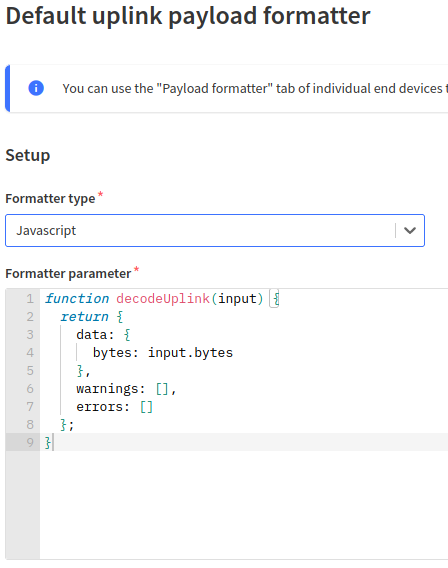## Autonomously send real sensor values to TTN

**Prerequisites:** You must have followed the [getting started with TTN notebook](../ttn-getting-started/ttn-getting-started.ipynb) before starting this one.

> We also consider that the application id is **iotlab-lorawan** and the device id is **iotlab-node** but you'll have to use the ids corresponding to your application and device configured in TTN.

In this notebook, you will write an autonomous LoRaWAN application with the following specifications:
- The application automatically connects to TTN at startup using the OTAA activation and a datarate index of 5
- In case of an activation issue, an error message is printed to the console and the application returns
- A message is printed to the console to confirm the success of the activation
- A message is sent periodically (check the duty cycle!) to the TTN backend. This message will first contain a basic string and in a second phase, it will contain the values measured on the temperature and humidity sensors.
- A message is printed to the console each time the message is sent with success.

We provide a starting RIOT application with a [Makefile](Makefile) and a [main.c](./main.c). The [Makefile](Makefile) is already configured but you will have to edit the [main.c](./main.c) by following the instructions of this Notebook.

### Configure the TTN payload format

Before we start coding the application, we need to change how the data is displayed in the **Live Data** tab of your TTN application.

You can change this format of the payload used to display the content of an uplink message in the `Payload formatters>Uplink` tab:

<figure style="text-align:center">
    <img src="images/application-tab-payload-format.png" width="448" align="center"/><br/><br/>
    <figcaption><em>Application `Payload formatters` tab in the TTN console</em></figcaption>
</figure>

1. Select `Javascript` in the drop down button.
2. Copy the following code snippet in the `decoder` text edit:

```js
function decodeUplink(input) {
var message = "";

for  (var i=0; i < input.bytes.length; i++) {
    message += String.fromCharCode(input.bytes[i]);
}

return {
    data: {
      message: message,
    },
    warnings: [],
    errors: []
  };
}
```
3. Click on the `Save changes` button at the end of the page

### Implement an autonomous RIOT application

The LoRaWAN API of RIOT is documented online at http://doc.riot-os.org/group__pkg__semtech-loramac.html.

Let's edit the [main.c](./main.c).

1. Add the necessary includes for the sx127x radio driver under the comment `/* Add sx127x radio driver necessary includes here */`:

```c
#include "sx127x.h"
#include "sx127x_netdev.h"
#include "sx127x_params.h"
```

2. Add the necessary includes for the loramac stack under the comment `/* Add loramac necessary includes here */`:


```c
#include "net/loramac.h"     /* core loramac definitions */
#include "semtech_loramac.h" /* package API */
```


3. Declare the global descriptor for the sx127x radio driver:

```c
static sx127x_t sx127x;      /* The sx127x radio driver descriptor */
```


4. Declare the global descriptor for the loramac stack:


```c
static semtech_loramac_t loramac;  /* The loramac stack descriptor */
```


5. Configure the identifiers (application and device) and the application key. You can find them in the device overview on TTN.


```c
static const uint8_t appeui[LORAMAC_APPEUI_LEN] = { 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00 };
static const uint8_t deveui[LORAMAC_DEVEUI_LEN] = { 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00 };
static const uint8_t appkey[LORAMAC_APPKEY_LEN] = { 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00 };
```

**note:** in the device overview on TTN, it's possible to switch the representation of the EUIs and key from an hexadecimal representation (the default) to a C byte array representation (the one that interests us here): use the `<>` button to switch from one to the other and keep the MSB order.

5. At the beginning of the main function, initialize the radio driver:

```c
    sx127x_setup(&sx127x, &sx127x_params[0], 0);
    loramac.netdev = &sx127x.netdev;
    loramac.netdev->driver = &sx127x_driver;
```

6. At the beginning of the main function, initialize the loramac stack:

```c
    semtech_loramac_init(&loramac);
```

7. Then, configure the keys:

```c
    semtech_loramac_set_deveui(&loramac, deveui);
    semtech_loramac_set_appeui(&loramac, appeui);
    semtech_loramac_set_appkey(&loramac, appkey);
```

8. All devices are very close to the gateway in IoT-LAB, so we can configure a fast datarate. Let's use DR5:

```c
    semtech_loramac_set_dr(&loramac, 5);
```

9. Add the logic to join the network using the OTAA activation:

```c
    if (semtech_loramac_join(&loramac, LORAMAC_JOIN_OTAA) != SEMTECH_LORAMAC_JOIN_SUCCEEDED) {
        puts("Join procedure failed");
        return 1;
    }
    puts("Join procedure succeeded");
```

10. Finally, in the `while` loop (under the comment `/* send the message here */`), send the message or continue if the message couldn't be sent:

```c
        if (semtech_loramac_send(&loramac,
                                 (uint8_t *)message, strlen(message)) != SEMTECH_LORAMAC_TX_DONE) {
            printf("Cannot send message '%s'\n", message);
        }
        else {
            printf("Message '%s' sent\n", message);
        }
```

11. Save the changes in main.c using the `Ctrl + s` keyboard shortcut and then verify that the application builds correctly:

In [10]:
!make

Building application "ttn-sensors" for "b-l072z-lrwan1" with MCU "stm32".

[INFO] cloning stm32cmsis
Cloning into '/home/jovyan/work/training/iot-lab-training/riot/RIOT/build/stm32/cmsis/l0'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 245 (delta 196), reused 230 (delta 181), pack-reused 0
Receiving objects: 100% (245/245), 267.72 KiB | 4.25 MiB/s, done.
Resolving deltas: 100% (196/196), done.
HEAD is now at 532d969 Release v1.9.2
[INFO] updating stm32cmsis /home/jovyan/work/training/iot-lab-training/riot/RIOT/build/stm32/cmsis/l0/.pkg-state.git-downloaded
echo 532d96973e7b2ae5546a2c88cb216429f74f5f5d   > /home/jovyan/work/training/iot-lab-training/riot/RIOT/build/stm32/cmsis/l0/.pkg-state.git-downloaded
[INFO] patch stm32cmsis
[INFO] cloning semtech-loramac
Cloning into '/home/jovyan/work/training/iot-lab-training/riot/RIOT/build/pkg/semtech-loramac'...
remote: Enumerating obje

### Start an experiment on IoT-LAB

Now that we have a ready application, we can try it on the real hardware provided remotely by IoT-LAB.

1. Submit an experiment with one LoRa device on IoT-LAB:

In [11]:
!iotlab-experiment submit -n "ttn-sensors" -d 120 -l 1,archi=st-lrwan1:sx1276+site=saclay

Using custom api_url: https://www.iot-lab.info/api/
{
    "id": 304134
}


2. Wait for the experiment to be in the "Running" state:

In [12]:
!iotlab-experiment wait --timeout 30 --cancel-on-timeout

Using custom api_url: https://www.iot-lab.info/api/
Waiting that experiment 304134 gets in state Running
"Running"


**Note:** If the command above returns the message `Timeout reached, cancelling experiment <exp_id>`, try to re-submit your experiment later.

3. Open a new terminal with the menu `File > New > Terminal` and in the terminal, run the following command to connect to the serial link of the LoRa board:

**It is normal if nothing is printed: there's normally no firmware running on the board. The firmware will be flashed during the next step**

**Keep this command running until the end of this notebook.**

4. Build and flash the application on the LoRa board:

In [13]:
!make IOTLAB_NODE=auto flash-only

Using custom api_url: https://www.iot-lab.info/api/
Using custom api_url: https://www.iot-lab.info/api/
Using custom api_url: https://www.iot-lab.info/api/
iotlab-node --jmespath='keys(@)[0]' --format='lambda ret: exit(int(ret))'  --list saclay,st-lrwan1,10 --flash /home/jovyan/work/training/iot-lab-training/riot/lorawan/ttn-sensors/bin/b-l072z-lrwan1/ttn-sensors.bin
Using custom api_url: https://www.iot-lab.info/api/


Once the flashing is complete, in the terminal, you should see the messages corresponding to the join procedure ("Join procedure succeeed") and the messages sent every 20s.

If the device cannot join, verify the configured EUIs and the application key.

If everything works as expected, you should see the decoded "This is RIOT!" messages appear in the **Live Data** tab of your application:


<figure style="text-align:center">
    <img src="images/ttn-decoded-messages-received.png" width="1262" align="center"/><br/><br/>
    <figcaption><em>Decoded messages received in the TTN console</em></figcaption>
</figure>

### Read the sensor values

Let's add the final step: read some sensor values from the [X-Nucleo extension shield](https://www.st.com/en/ecosystems/x-nucleo-iks01a2.html).

The X-Nucleo extension shield provides several ST Microelectronics sensors including the **HTS221** which measures temperature and humidity. The microcontroller interacts with this sensor using the [I2C serial bus](https://en.wikipedia.org/wiki/I%C2%B2C).

Let's now edit the [Makefile](Makefile) and [main.c](main.c) to read this sensor.

1. To be able to use the _hts221_ sensor with RIOT, you must first load the corresponding RIOT module in the application's [Makefile](Makefile). Add the following line to the Makefile (under the addition of the `ztimer_msec` module):


```mk
USEMODULE += hts221
```

All dependency modules required by the sensor driver will be loaded automatically during compilation, in particular the I2C bus driver used by the board to communicate with the sensor.

2. In the [main.c](main.c) file, Add the necessary header inclusions first (just below `#includes "semtech_loramac.h"`):


```c
#include "hts221.h"
#include "hts221_params.h"
```


3. Declare the variable containing the driver descriptor of the sensor (below the declaration of the `loramac` variable):

```c
static hts221_t hts221;
```

4. At the very beginning of the `main` function, add this sensor driver initialization sequence:

```c
    if (hts221_init(&hts221, &hts221_params[0]) != HTS221_OK) {
        puts("Sensor initialization failed");
        return 1;
    }

    if (hts221_power_on(&hts221) != HTS221_OK) {
        puts("Sensor initialization power on failed");
        return 1;
    }

    if (hts221_set_rate(&hts221, hts221.p.rate) != HTS221_OK) {
        puts("Sensor continuous mode setup failed");
        return 1;
    }
```

This sequence is adapted from the [hts221 test appplication](https://github.com/RIOT-OS/RIOT/blob/master/tests/driver_hts221/main.c#L34-L45).

5. Finally, add the following code at the beginning of the `while` loop to read the sensor data. You can also delete the line `char *message = "This is RIOT!"`
which is now useless:

```c
        /* do some measurements */
        uint16_t humidity = 0;
        int16_t temperature = 0;
        if (hts221_read_humidity(&hts221, &humidity) != HTS221_OK) {
            puts("Cannot read humidity!");
        }
        if (hts221_read_temperature(&hts221, &temperature) != HTS221_OK) {
            puts("Cannot read temperature!");
        }

        char message[64];
        sprintf(message, "H: %d.%d%%, T:%d.%dC",
                (humidity / 10), (humidity % 10),
                (temperature / 10), (temperature % 10));
        printf("Sending message '%s'\n", message);
```

6. Build and flash the new application to the LoRa board of your experiment:

In [14]:
!pwd

/home/jovyan/work/training/iot-lab-training/riot/lorawan/ttn-sensors


In [15]:
!make IOTLAB_NODE=auto flash

Using custom api_url: https://www.iot-lab.info/api/
Using custom api_url: https://www.iot-lab.info/api/
Using custom api_url: https://www.iot-lab.info/api/
Building application "ttn-sensors" for "b-l072z-lrwan1" with MCU "stm32".

"make" -C /home/jovyan/work/training/iot-lab-training/riot/RIOT/pkg/semtech-loramac
"make" -C /home/jovyan/work/training/iot-lab-training/riot/RIOT/build/pkg/semtech-loramac/src/boards/mcu -f /home/jovyan/work/training/iot-lab-training/riot/RIOT/pkg/semtech-loramac/Makefile.loramac_arch
"make" -C /home/jovyan/work/training/iot-lab-training/riot/RIOT/build/pkg/semtech-loramac/src/system/crypto -f /home/jovyan/work/training/iot-lab-training/riot/RIOT/pkg/semtech-loramac/Makefile.loramac_crypto
"make" -C /home/jovyan/work/training/iot-lab-training/riot/RIOT/build/pkg/semtech-loramac/src/mac -f /home/jovyan/work/training/iot-lab-training/riot/RIOT/pkg/semtech-loramac/Makefile.loramac_mac
"make" -C /home/jovyan/work/training/iot-lab-training/riot/RIOT/build/pkg/se

Now you can switch back to the terminal that is connected to the serial port of the LoRa board: **a new join procedure should be performed and the sensor data are sent every 20s to TTN**.

<figure style="text-align:center">
    <img src="images/ttn-sensor-data.png" width="1332" align="center"/><br/><br/>
    <figcaption><em>Sensor data received in the TTN console</em></figcaption>
</figure>


### Free up the resources

Since you finished the training, stop your experiment to free up the experiment nodes:

In [16]:
!iotlab-experiment stop

Using custom api_url: https://www.iot-lab.info/api/
{
    "id": 304134,
    "status": "Delete request registered"
}


The serial link connection through SSH will be closed automatically.